In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import rasterio 
from rasterio.plot import  show, adjust_band
from rasterio.mask import mask
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings 
from os import listdir
from visualisation_scripts import get_maps
from datetime import datetime as dt

warnings = False

%load_ext autoreload
%autoreload 2

In [2]:
from visualisation_scripts import get_maps

## Подготовка данных

In [3]:
archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')


archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')

archangelskiy['вес'] =archangelskiy['вес'] - archangelskiy['тара']
archangelskiy['вес [ц/га]'] = archangelskiy['вес'] * 4 * (10000) / 1000 / 100 # переход в Ц/Га
archangelskiy = archangelskiy[['точка', '%', 'вес [ц/га]']]
archangelskiy = archangelskiy.groupby('точка').mean().reset_index()
archangelskiy.columns = ['type', 'perc [%] полевой',"вес [ц/га] полевой" ]

archangelskiy_cameral = pd.read_csv('points_gps/cameral_crc.csv', encoding = "ANSI", sep =';')
archangelskiy_cameral = archangelskiy_cameral[['name', '%']].groupby('name').mean().reset_index()
archangelskiy_cameral.columns = ['type' , 'perc [%] камеральный']


archangelskiy = archangelskiy.merge(archangelskiy_cameral, on = 'type', how = 'outer')
archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный
0,525,62.50,21.4,82.000000
1,526,81.25,41.5,89.714286
2,527,68.75,32.5,96.857143
3,528,68.75,24.0,80.285714
4,586,96.75,62.4,87.142857
5,587,43.75,38.9,30.000000
6,588,33.75,27.4,30.571429


#### точки

In [4]:
archangelskiy_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
archangelskiy_points.columns = ['type',"geometry" ]
archangelskiy_points

,type,geometry
0,525,POINT Z (44.18418 44.55136 170.78041)
1,526,POINT Z (44.18086 44.54805 167.81140)
2,527,POINT Z (44.17407 44.54223 164.98230)
3,528,POINT Z (44.16865 44.54459 169.67947)
4,529,POINT Z (44.16700 44.53811 175.87118)
5,585,POINT Z (44.16801 44.53532 172.00731)
6,586,POINT Z (44.17582 44.54182 160.97470)
7,587,POINT Z (44.18650 44.54988 162.74657)
8,588,POINT Z (44.18876 44.54880 163.77283)


#### Пример растра и его выходные данные

In [5]:
Raster_at_moment = rasterio.open('raster_data/Field_scale_sentinel2_2021-09-21_scene.tif')
NDVI_at_moment_array = Raster_at_moment.read()[6]
NDTI_at_monent_array = Raster_at_moment.read()[7]

NDTI = NDTI_at_monent_array.copy()
NDTI[NDVI_at_moment_array >= 0.3] = np.nan #маска

NDVI_mask = (NDVI_at_moment_array >= 0.3).astype('int')

metadata = Raster_at_moment.meta

metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 369,
 'height': 401,
 'count': 8,
 'crs': CRS.from_epsg(32638),
 'transform': Affine(10.0, 0.0, 432290.0,
        0.0, -10.0, 4934320.0)}

#### Визуализация растра

[Text(0.5, 1.0, 'NDTI 2021-09-21 \n(на момент проведения полевых работ)')]

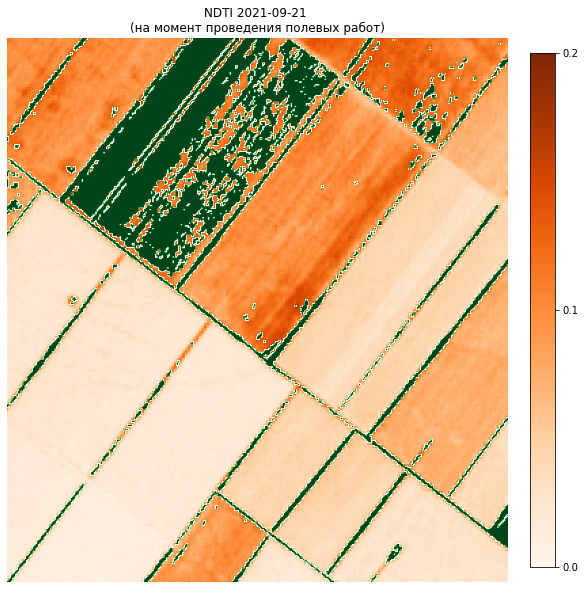

In [6]:
fig, axes = plt.subplots( figsize=(10,10)) 

NDTI_hiden_layer = axes.imshow(NDVI_mask, cmap='Greens')
NDTI_vis = axes.imshow(NDTI, cmap='Oranges')
NDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
fig.colorbar(NDTI_vis, fraction=0.046, pad=0.04, ax=axes).set_ticks([ 0,0.1,0.2])
axes.axis('off')
axes.set(title = 'NDTI 2021-09-21 \n(на момент проведения полевых работ)')



#### Формула для теоретического расчета растительных остатков

In [7]:

def RC_cover(x):
    rc = (m * x) + b 
    return(rc)


NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)]
top = NDTI_arr.mean() + (3 * NDTI_arr.std())
bottom = NDTI_arr.mean() - (3 * NDTI_arr.std())
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_std_method = RC_cover(NDTI)




In [8]:
rasters_dict = {'NDTI в моменте' : NDTI,
                "имперический NDTI +-3 стнд.откл" : imperic_crc_std_method
}


def extract_values_to_points(raster,points_df):
    X_ = points_df.to_crs(metadata['crs']).geometry.x
    Y_ = points_df.to_crs(metadata['crs']).geometry.y
    points_dict ={}
    for i in range(len(points_df['type'])):
        ind = (Raster_at_moment.index(X_[i],Y_[i]))
        points_dict[points_df['type'][i]] = raster[ind[0], ind[1]]
    df = pd.DataFrame.from_dict(points_dict, orient='index',).reset_index()
    return(df)

for method in rasters_dict.keys():
    df = extract_values_to_points(rasters_dict[method],archangelskiy_points)
    df.columns = ["type", method]
    df['type'] = df['type'].astype('int64')
    archangelskiy = archangelskiy.merge(df, on = 'type', how = 'outer')

archangelskiy = archangelskiy.fillna(value = 0)

archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный,NDTI в моменте,имперический NDTI +-3 стнд.откл
0,525,62.50,21.4,82.000000,0.121709,0.729161
1,526,81.25,41.5,89.714286,0.115793,0.704579
2,527,68.75,32.5,96.857143,0.130336,0.765008
3,528,68.75,24.0,80.285714,0.099462,0.636720
4,586,96.75,62.4,87.142857,0.131532,0.769976
5,587,43.75,38.9,30.000000,0.049634,0.429673
6,588,33.75,27.4,30.571429,0.039044,0.385671
7,529,0.00,0.0,0.000000,0.022754,0.317983
8,585,0.00,0.0,0.000000,0.019031,0.302511


<AxesSubplot:>

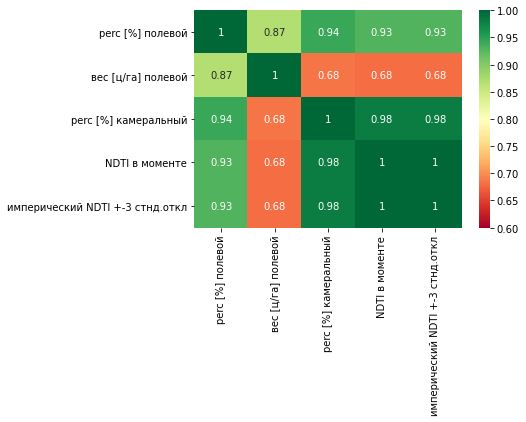

In [9]:
sns.heatmap(archangelskiy.iloc[:,1:].corr(), vmin=0.6 , vmax=1, annot=True, cmap = 'RdYlGn')

## Моделирование данных

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score 

Модель, которая на выход дает значения

In [11]:
def line_regression(df):
    """
    на вход df с двумя колонками - 1я по чему учимся, 2я полевые значения
    на выход 
    fig -  граффик
    model - уже обученная модель 
    R2 - коэффициент детерминации
    MSE - средний квадрат ошибки
    """
    litle_df = df.copy()
    X = litle_df.iloc[:,0].values.reshape(-1,1)
    y = litle_df.iloc[:,1].values.reshape(-1,1)
    model = LinearRegression()
    model.fit(X ,y)
    Y_ = model.predict(X)
    litle_df['predicted'] = Y_

    R2 = round(model.score(X,y) , 2)
    mse = round(MSE(y, Y_), 2)

    coef = round(model.coef_[0][0] , 2)
    intecept = round(model.intercept_[0],2)
    if str(intecept)[0] == '-':
        sign = ''
    else:
        sign = '+'
    return({"модель" : model,
            'предиктор' :  coef,
            'интерсепт' : (sign + str(intecept) ),
            'R2' : R2,
            "MSE" : mse,
            'предсказания' : Y_
    })

In [12]:
model1 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] полевой" ]]) #NDTI в момент полевых работ и полевые данные о площади покрытия
model2 =  line_regression(archangelskiy[["NDTI в моменте","вес [ц/га] полевой" ]]) #NDTI в момент полевых работ и полевой весовой анализ
model3 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] камеральный" ]]) #NDTI в момент полевых работ и камеральные данные о площади покрытия

### NDTI в моменте"/"perc [%] полевой

Text(0.02, 85, 'MSE = 137.85')

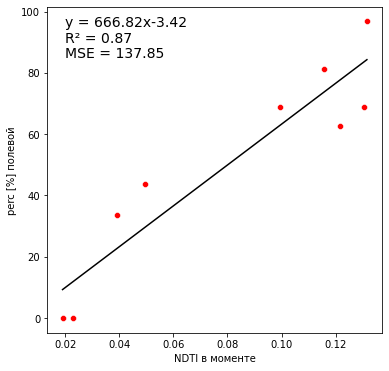

In [13]:
model1 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] полевой" ]]) #NDTI в момент полевых работ и полевые данные о площади покрытия

litle_df = archangelskiy[["NDTI в моменте","perc [%] полевой" ]].copy()

predictions = np.array(model1['предсказания']).reshape(-1)
mse = model1["MSE"]
R2 = model1["R2"]

intercept = model1["интерсепт"]
predictor = model1["предиктор"]


fig , axes = plt.subplots(1,1, figsize=(6,6)) 
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'red', ax = axes)
plot = sns.lineplot(x = litle_df.iloc[:,0],y =  predictions , color = 'black', ax = axes)
axes.text(0.02, 95, f"y = {predictor}x{intercept}", horizontalalignment='left', size=14, color='black')
axes.text(0.02, 90, f"R\u00b2 = {R2}" , horizontalalignment='left', size=14, color='black')
axes.text(0.02, 85, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')


### NDTI в моменте,вес [ц/га] полевой

Text(0.02, 55, 'MSE = 186.54')

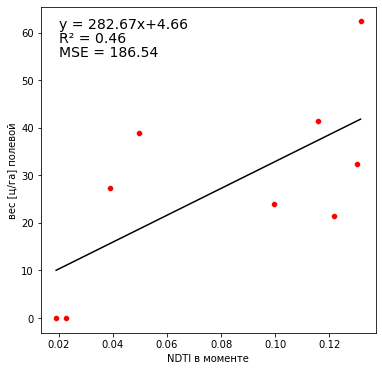

In [14]:
model2 =  line_regression(archangelskiy[["NDTI в моменте","вес [ц/га] полевой" ]]) #NDTI в момент полевых работ и полевой весовой анализ

litle_df = archangelskiy[["NDTI в моменте","вес [ц/га] полевой" ]].copy()

predictions = np.array(model2['предсказания']).reshape(-1)
mse = model2["MSE"]
R2 = model2["R2"]

intercept = model2["интерсепт"]
predictor = model2["предиктор"]


fig , axes = plt.subplots(1,1, figsize=(6,6)) 
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'red', ax = axes)
plot = sns.lineplot(x = litle_df.iloc[:,0],y =  predictions , color = 'black', ax = axes)
axes.text(0.02, 61, f"y = {predictor}x{intercept}", horizontalalignment='left', size=14, color='black')
axes.text(0.02, 58, f"R\u00b2 = {R2}" , horizontalalignment='left', size=14, color='black')
axes.text(0.02, 55, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')


### NDTI в моменте/perc [%] камеральный

Text(0.02, 85, 'MSE = 48.89')

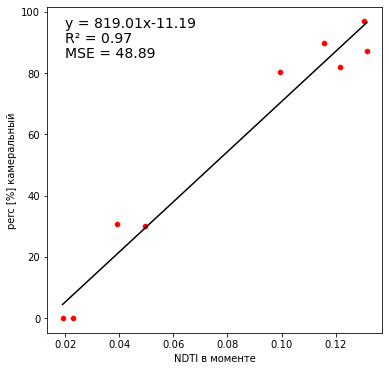

In [15]:
model3 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] камеральный" ]]) #NDTI в момент полевых работ и камеральные данные о площади покрытия

litle_df = archangelskiy[["NDTI в моменте","perc [%] камеральный" ]].copy()

predictions = np.array(model3['предсказания']).reshape(-1)
mse = model3["MSE"]
R2 = model3["R2"]

intercept = model3["интерсепт"]
predictor = model3["предиктор"]


fig , axes = plt.subplots(1,1, figsize=(6,6)) 
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'red', ax = axes)
plot = sns.lineplot(x = litle_df.iloc[:,0],y =  predictions , color = 'black', ax = axes)
axes.text(0.02, 95, f"y = {predictor}x{intercept}", horizontalalignment='left', size=14, color='black')
axes.text(0.02, 90, f"R\u00b2 = {R2}" , horizontalalignment='left', size=14, color='black')
axes.text(0.02, 85, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')


### имперический NDTI +-3 стнд.откл/"perc [%] камеральный"

Text(0.02, 85, 'MSE = 378.33')

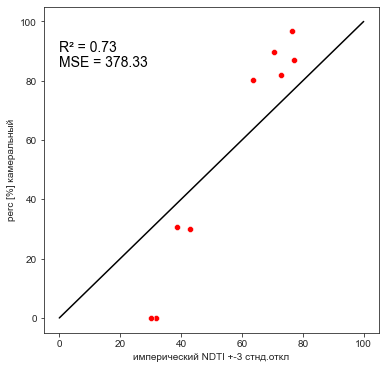

In [39]:
x = archangelskiy["имперический NDTI +-3 стнд.откл"] * 100
y = archangelskiy["perc [%] камеральный"]
mse = round(MSE(y, x), 2)
R2 = round(r2_score(y, x), 2)
fig , axes = plt.subplots(1,1, figsize=(6,6)) 

plot = sns.scatterplot(x = x, y = y, color = 'red', ax = axes)
plot = sns.lineplot(x = [0,10,20,30, 100], y = [0,10,20,30, 100], color = 'black', ax = axes)
axes.text(0.02, 90, f"R\u00b2 = {R2}" , horizontalalignment='left', size=14, color='black')
axes.text(0.02, 85, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')

0    82.000000
1    89.714286
2    96.857143
3    80.285714
4    87.142857
5    30.000000
6    30.571429
7     0.000000
8     0.000000
Name: perc [%] камеральный, dtype: float64

### имперический NDTI +-3 стнд.откл/perc [%] полевой

Text(0.02, 85, 'MSE = 294.56')

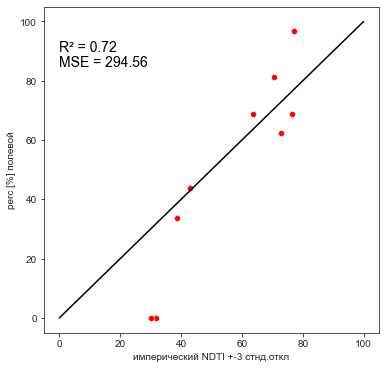

In [40]:
x = archangelskiy["имперический NDTI +-3 стнд.откл"] * 100
y = archangelskiy["perc [%] полевой"]
mse = round(MSE(y, x), 2)
R2 = round(r2_score(y, x), 2)
fig , axes = plt.subplots(1,1, figsize=(6,6)) 

plot = sns.scatterplot(x = x, y = y, color = 'red', ax = axes)
plot = sns.lineplot(x = [0,10,20,30, 100], y = [0,10,20,30, 100], color = 'black', ax = axes)
axes.text(0.02, 90, f"R\u00b2 = {R2}" , horizontalalignment='left', size=14, color='black')
axes.text(0.02, 85, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')

## Обработка растров на основании полученной модели

In [18]:
"""
Так как уже все скачано и обработано этот шаг можно пропустить
ИНАЧЕ ПРИДЕТСЯ ПО НОВОЙ ВРУЧНУЮ ЧИСТИТЬ ДАННЫЕ!!!!!!!!! 
rasters = listdir("raster_data/for_modeling")

for raster in rasters:
    
    #Обработка растров в полученной модели
    
    file_name = "raster_data/for_modeling/" + raster
    raster_for_classify = rasterio.open(file_name) 


    metadata = raster_for_classify.meta
    metadata['count'] = 2

    raster_shape = raster_for_classify.read()[6].shape

    NDVI = raster_for_classify.read()[6]
    NDTI = raster_for_classify.read()[7]

    NDTI[NDVI >= 0.3] = 0 #создание маски для NDVI

    predicted = model3['модель'].predict(NDTI.reshape(-1, 1)).T
    CRC = predicted.reshape(raster_shape).astype('float32')
    CRC[CRC >= 100] = 100
    CRC[CRC <= 0] = 0


    ready_img = np.array([NDVI,CRC ])

    new_dataset = rasterio.open(f"raster_data/CRC/CRC{raster}", 'w', **metadata)
    new_dataset.write(ready_img)
    new_dataset.close()
CRC_rasters_dirs = listdir("raster_data/CRC")

archangelskiy_points_reprojected = archangelskiy_points.to_crs(metadata["crs"])
archangelskiy_points_reprojected.geometry =  archangelskiy_points_reprojected.buffer(distance  = 75)
def get_values(raster, geometry):
    
    #на вход растер (в данном случае канал 0 - NDVI  канал 1 - CRC)
    #geometry - geopandas фаил где type - имя обьекта 
    

    point_df = pd.DataFrame()
    date = raster.name.split("/")[-1]
    date = date.split('_')[3]

    unique_objects = geometry['type'].unique()
    for objects in unique_objects:

        litle_df = pd.DataFrame()
        geo = geometry[geometry['type'] == objects]
        arr, _ = mask(raster , shapes = geo.geometry.geometry, nodata=-10 )

        NDVI_arr = arr[0].reshape(-1) #массив NDVI
        NDVI_arr = NDVI_arr[NDVI_arr != -10]
        

        CRC_arr = arr[1].reshape(-1) #массив CRC 
        CRC_arr = CRC_arr[CRC_arr !=-10]
        

        
        litle_df['NDV_values'] = NDVI_arr
        litle_df['CRC_values'] = CRC_arr
        litle_df["date"] = date
        litle_df['type'] = objects
        litle_df = litle_df.sample(n = 10, random_state= 14)

        point_df = point_df.append(litle_df)
    
    return(point_df)
"""

'\nТак как уже все скачано и обработано этот шаг можно пропустить\nИНАЧЕ ПРИДЕТСЯ ПО НОВОЙ ВРУЧНУЮ ЧИСТИТЬ ДАННЫЕ!!!!!!!!! \nrasters = listdir("raster_data/for_modeling")\n\nfor raster in rasters:\n    \n    #Обработка растров в полученной модели\n    \n    file_name = "raster_data/for_modeling/" + raster\n    raster_for_classify = rasterio.open(file_name) \n\n\n    metadata = raster_for_classify.meta\n    metadata[\'count\'] = 2\n\n    raster_shape = raster_for_classify.read()[6].shape\n\n    NDVI = raster_for_classify.read()[6]\n    NDTI = raster_for_classify.read()[7]\n\n    NDTI[NDVI >= 0.3] = 0 #создание маски для NDVI\n\n    predicted = model3[\'модель\'].predict(NDTI.reshape(-1, 1)).T\n    CRC = predicted.reshape(raster_shape).astype(\'float32\')\n    CRC[CRC >= 100] = 100\n    CRC[CRC <= 0] = 0\n\n\n    ready_img = np.array([NDVI,CRC ])\n\n    new_dataset = rasterio.open(f"raster_data/CRC/CRC{raster}", \'w\', **metadata)\n    new_dataset.write(ready_img)\n    new_dataset.close(

In [19]:
def get_values(raster, geometry):
    
    #на вход растер (в данном случае канал 0 - NDVI  канал 1 - CRC)
    #geometry - geopandas фаил где type - имя обьекта 
    

    point_df = pd.DataFrame()
    date = raster.name.split("/")[-1]
    date = date.split('_')[3]

    unique_objects = geometry['type'].unique()
    for objects in unique_objects:

        litle_df = pd.DataFrame()
        geo = geometry[geometry['type'] == objects]
        arr, _ = mask(raster , shapes = geo.geometry.geometry, nodata=-10 )

        NDVI_arr = arr[0].reshape(-1) #массив NDVI
        NDVI_arr = NDVI_arr[NDVI_arr != -10]
        

        CRC_arr = arr[1].reshape(-1) #массив CRC 
        CRC_arr = CRC_arr[CRC_arr !=-10]
        

        
        litle_df['NDV_values'] = NDVI_arr
        litle_df['CRC_values'] = CRC_arr
        litle_df["date"] = date
        litle_df['type'] = objects
        litle_df = litle_df.sample(n = 10, random_state= 14)

        point_df = point_df.append(litle_df)
    
    return(point_df)


In [20]:
# по полям 
CRC_rasters_dirs = listdir("raster_data/CRC")

tree_fields = gpd.read_file('points_gps/3fields.geojson')
tree_fields = tree_fields.to_crs(metadata['crs'])
result_fields_df = pd.DataFrame()
for rast  in CRC_rasters_dirs:
    raster_dir = "raster_data/CRC/" + rast
    raster = rasterio.open(raster_dir)
    one_date_df = get_values(raster , tree_fields)
    result_fields_df = result_fields_df.append(one_date_df)
    
# result_fields_df датафрейм с данными по полям 

result_fields_df = result_fields_df.drop_duplicates()
result_fields_df['date'] = pd.to_datetime(result_fields_df['date'] )
result_fields_df["CRC_values"][result_fields_df['NDV_values'] > 0.3] = np.NaN


C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
archangelskiy_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
archangelskiy_points.columns = ['type',"geometry" ]

PP_points = ['525', "526", '527', '528', "586"]
only_pp_points = archangelskiy_points[archangelskiy_points['type'].isin(PP_points)]

only_pp_points = only_pp_points.to_crs(metadata['crs'])
only_pp_points["geometry"] = only_pp_points.buffer(50) # буфер 50 метров 


result_points_df = pd.DataFrame()

for rast  in CRC_rasters_dirs:
    raster_dir = "raster_data/CRC/" + rast
    raster = rasterio.open(raster_dir)
    one_date_df = get_values(raster , only_pp_points)
    result_points_df = result_points_df.append(one_date_df)

result_points_df = result_points_df.drop_duplicates()
result_points_df['date'] = pd.to_datetime(result_points_df['date'] )
result_points_df["CRC_values"][result_points_df['NDV_values'] > 0.3] = np.NaN

C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
import matplotlib.dates as mdates
from visualisation_scripts import weather_visualisation

weather_dir = "climat_data_archangelskoe_3Years.csv"

In [33]:
df = result_fields_df[(result_fields_df['date'] > f"{2020}-11-15") & (result_fields_df['date'] < f"{(2021+1)}-11-15" )]
len(df.date.unique())

14

In [23]:
def for_field_ploting(year):
    preparing_df = result_fields_df[(result_fields_df['date'] > f"{year}-11-15") & (result_fields_df['date'] < f"{(year+1)}-11-15" )]


    fig, ax1 = plt.subplots( figsize=(10,6))

    formatter = mdates.DateFormatter('%Y-%m-%d')
    NDVI_plot = sns.lineplot(data = preparing_df , x = 'date', y = 'NDV_values',hue = 'type',ci = None,linestyle="dashed",linewidth = 3, alpha=0.6, ax = ax1)
    NDVI_plot.xaxis.set_major_formatter(formatter)
    NDVI_plot.axhline(0.3, color = '#407A15',linewidth = 5, alpha = 0.7)
    ax1.legend(title = 'Объект',  labels=['прямой посев 1', 'традиционная технология', 'прямой посев 2'] )
    ax1.set(ylim = (0 , 1), ylabel='NDVI',xlabel = "")
    ax1 = ax1.twinx()


    crc_df = preparing_df[(preparing_df['date'] > f"{(year+1)}-06-01") & (preparing_df['date'] < f"{(year+1)}-11-15" )]

    date_no_veg = crc_df.dropna(axis = 0).iloc[0,2] #первая дата без вегетации

    NDVI_plot.axvline(date_no_veg, color = 'r',linewidth = 5, alpha = 0.7)
    CRC_plot = sns.lineplot(data = crc_df , x = 'date', y = 'CRC_values', hue = 'type',marker="o",linewidth = 3,  ax =  ax1)
    ax1.set(ylim = (-70 , 150), ylabel='CRC [%]',xlabel = "")
    ax1.set_yticklabels(labels = ['','','',0,25,50,75,100])
    ax1.legend(title = 'Объект',  labels=['прямой посев 1', 'традиционная технология', 'прямой посев 2'] )


In [24]:
def for_point_ploting(year):
    preparing_df = result_points_df[(result_points_df['date'] > f"{year}-11-15") & (result_points_df['date'] < f"{(year + 1)}-11-15" )]
    fig, ax1 = plt.subplots(figsize=(10,6))


    formatter = mdates.DateFormatter('%Y-%m-%d')
    NDVI_plot = sns.lineplot(data = preparing_df , x = 'date', y = 'NDV_values',hue = 'type',ci = None,linestyle="dashed",linewidth = 3, alpha=0.6, ax = ax1)
    NDVI_plot.xaxis.set_major_formatter(formatter)
    NDVI_plot.axhline(0.3, color = '#407A15',linewidth = 5, alpha = 0.7)
    ax1.legend(title = 'Точка GPS (рад 50м.)',  labels=['525', '526', '527',"528" , '586'] )
    ax1.set(ylim = (0 , 1), ylabel='NDVI',xlabel = "")
    ax1 = ax1.twinx()

    crc_df = preparing_df[(preparing_df['date'] > f"{(year + 1)}-06-01") & (preparing_df['date'] < f"{(year + 1)}-11-15" )]

    date_no_veg = crc_df.dropna(axis = 0).iloc[0,2] #первая дата без вегетации


    NDVI_plot.axvline(date_no_veg, color = 'r',linewidth = 5, alpha = 0.7)
    CRC_plot = sns.lineplot(data = crc_df , x = 'date', y = 'CRC_values', hue = 'type',marker="o",linewidth = 3,  ax =  ax1)
    ax1.set(ylim = (-70 , 150), ylabel='CRC [%]',xlabel = "")
    ax1.set_yticklabels(labels = ['','','',0,25,50,75,100])
    ax1.legend(title = 'Точка GPS (рад 50м.)',  labels=['525', '526', '527',"528" , '586'] )

C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


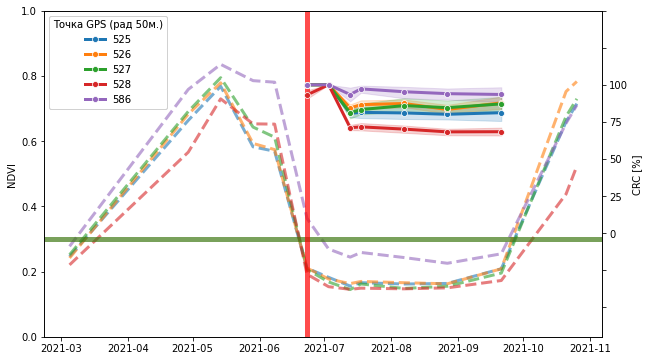

In [25]:
for_point_ploting(2020)

## 2018-2019

C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


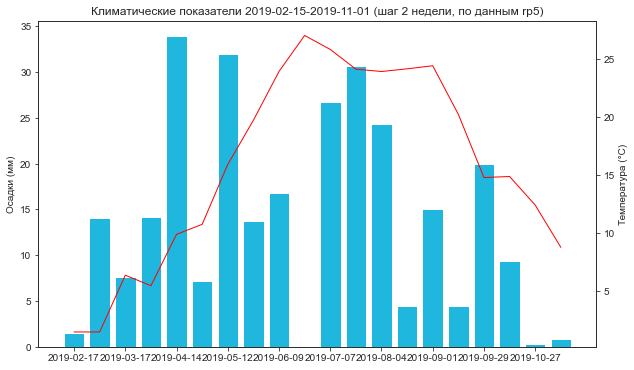

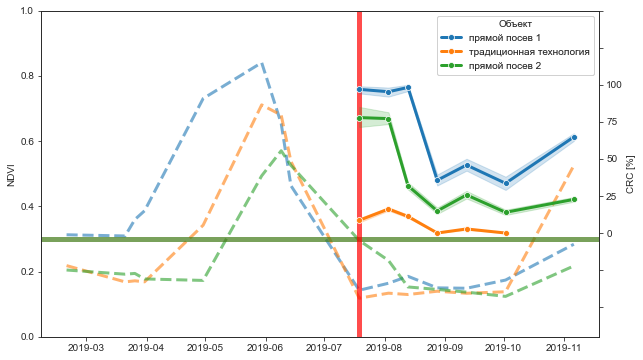

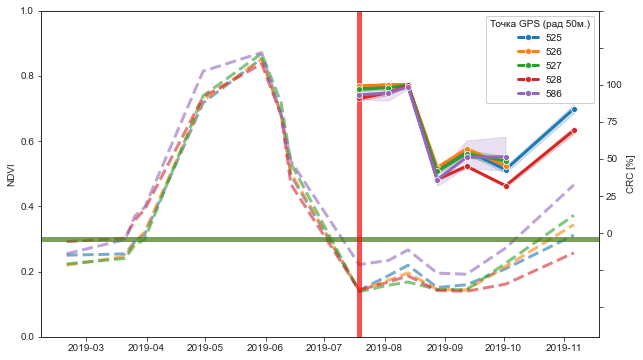

In [26]:

weather_visualisation("2019-02-15","2019-11-01",weather_dir )
for_field_ploting(2018)
for_point_ploting(2018)


## 2019-2020

C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


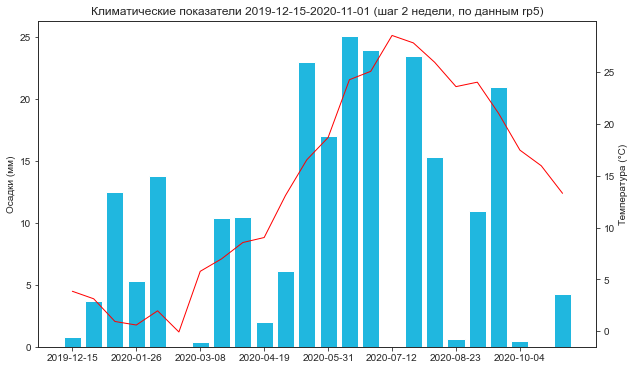

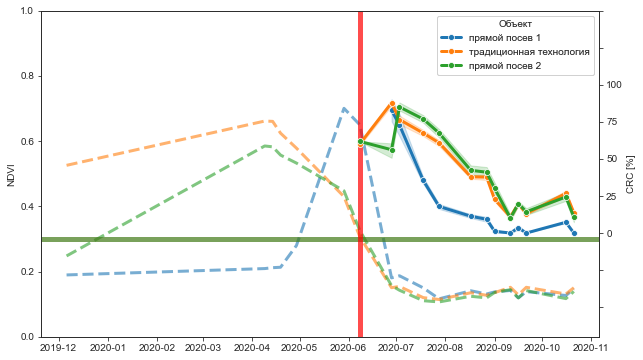

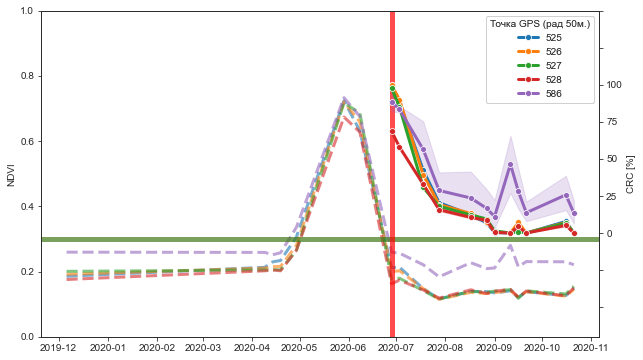

In [27]:
weather_visualisation("2019-12-15","2020-11-01",weather_dir )
for_field_ploting(2019)
for_point_ploting(2019)


## 2020-2021

C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


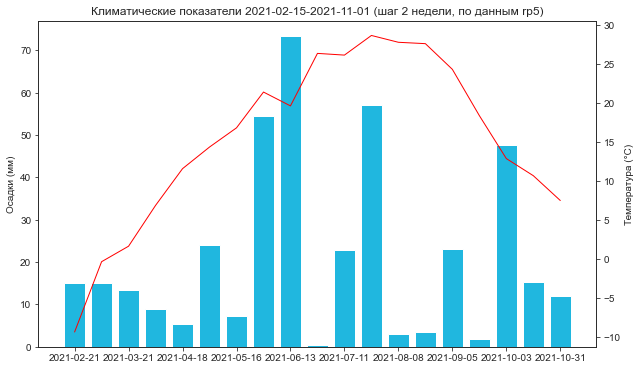

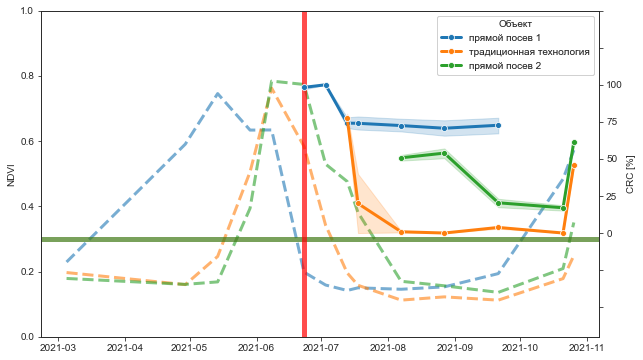

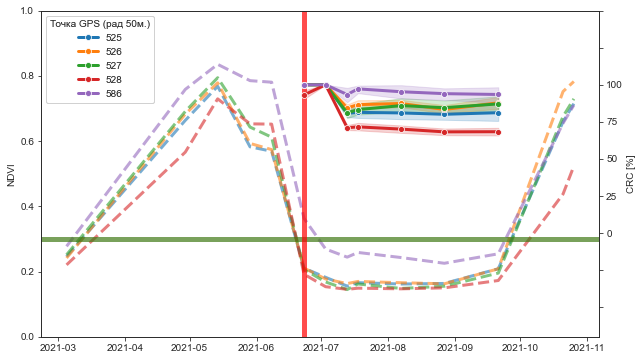

In [28]:
weather_visualisation("2021-02-15","2021-11-01",weather_dir )
for_field_ploting(2020)
for_point_ploting(2020)